# DMS - Data Analysis

In [9]:
import os
import pandas as pd
from abag_affinity.utils.config import read_config, get_data_paths
import matplotlib.pyplot as plt
import seaborn as sns

config = read_config("../../config.yaml")
summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["summary"])

In [10]:
publications = os.listdir(os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"]))
publications = [ ".".join(pub.split(".")[:-1]) for pub in publications if ".csv" in pub]
publications

['madan21_mutat_hiv',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_3',
 'wu20_differ_ha_h3_h1',
 'taft22_deep_mutat_learn_predic_ace2',
 'b.20_funct_screen_strat_engin_chimer',
 'phillips21_bindin',
 'mason21_optim_therap_antib_by_predic_dms_H',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_2',
 'mason21_comb_optim_therap_antib_by_predic_combined_L3_3',
 'wu17_in',
 'starr21_prosp_covid',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_1',
 'mason21_optim_therap_antib_by_predic_dms_L']

In [11]:
full_dms_df = pd.read_csv(os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["DMS"]["folder_path"], config["RESOURCES"]["DMS"]["info"]))
full_dms_df = full_dms_df[~full_dms_df["publication"].str.startswith("taft22")]

all_complexes = full_dms_df.groupby(["publication", "antibody", "antigen"])

In [12]:
dfs = []
for publication in publications:
    df = pd.read_csv(os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], f"{publication}.csv"), index_col=0)
    dfs.append(df)

    
dms_df = pd.concat(dfs)

In [59]:
dms_df[dms_df["publication"] == "wu17_in"]["mutation_code"].unique()

array(['original'], dtype=object)

In [13]:
dms_df[["publication", "antibody", "antigen"]] = dms_df["pdb"].str.split(':', 2, expand=True)

In [14]:
dms_df = dms_df.reset_index(drop=True)

In [15]:
complexes = dms_df.groupby(["publication", "antibody", "antigen"])

In [16]:
# add also not generated complexes
complexes_not_generated = set(all_complexes.groups.keys()) - set(complexes.groups.keys())
complexes_not_generated_df = pd.DataFrame(complexes_not_generated, columns=["publication", "antibody", "antigen"])
complexes_not_generated_df["mutation_code"] = ""

generated_complexes_count = pd.concat([
    complexes["mutation_code"].count(),
    complexes_not_generated_df.groupby(["publication", "antibody", "antigen"])["mutation_code"].count()
]).sort_index()

### Number of mutations for complex

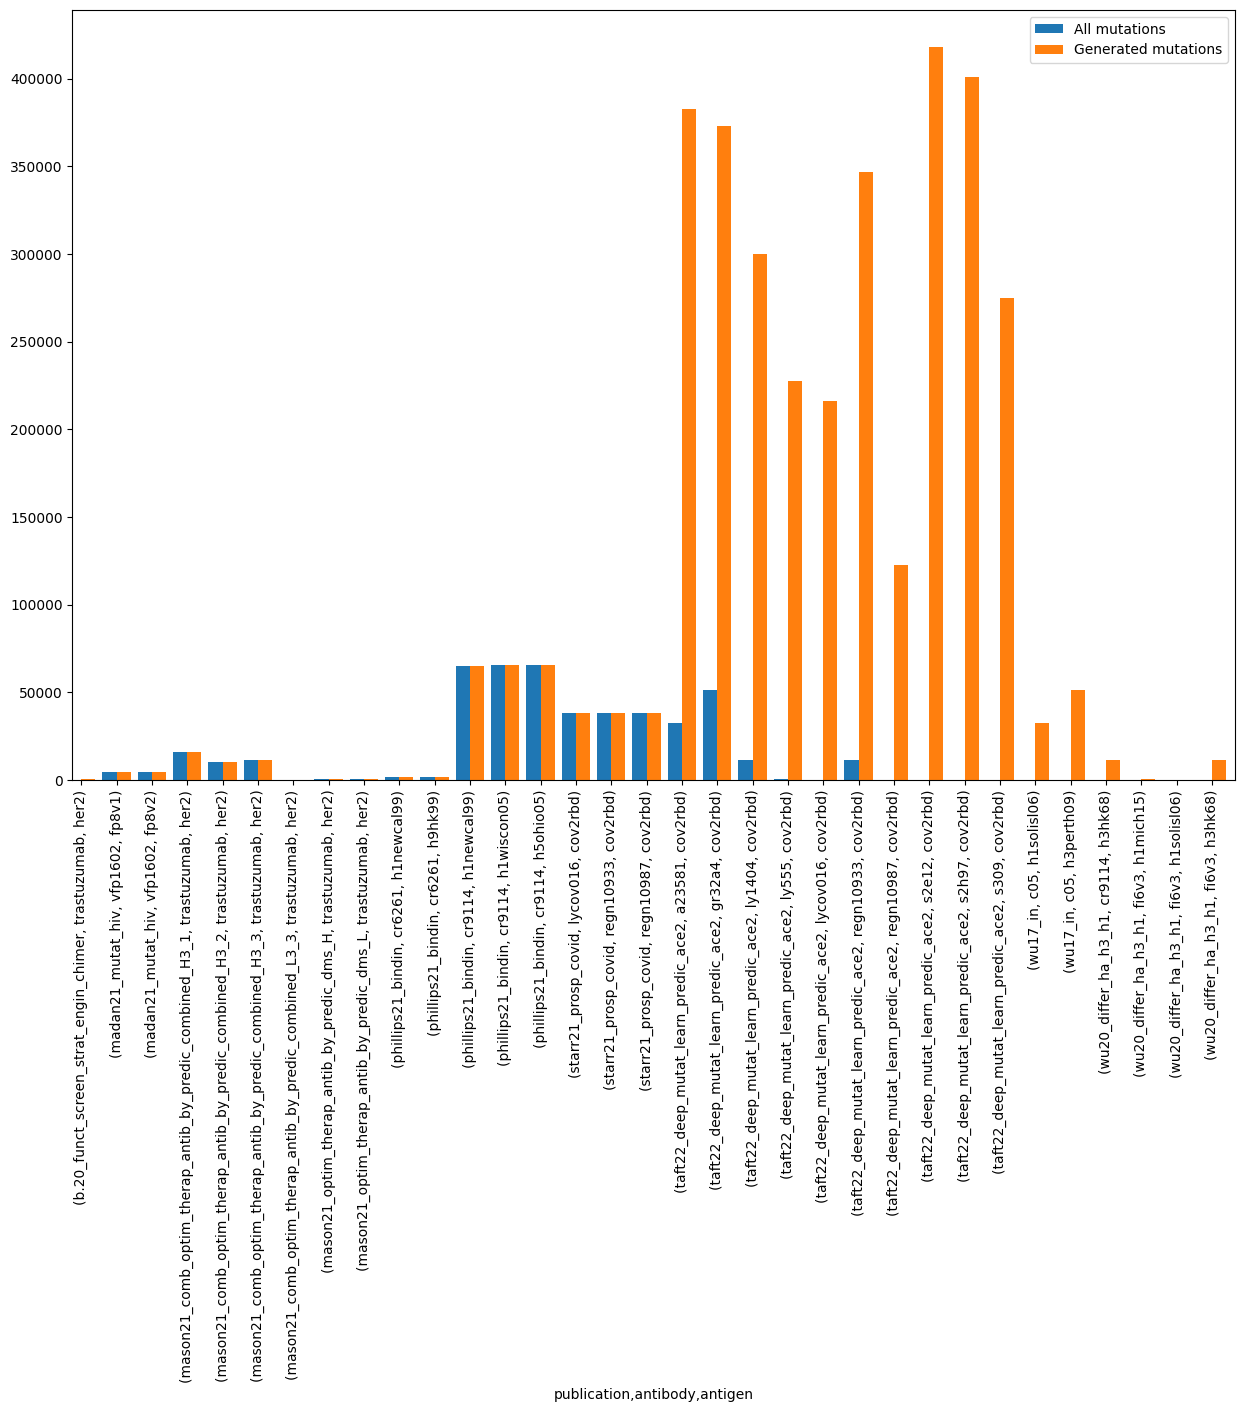

In [26]:
colors = sns.color_palette()
# check if all data points are available
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111) 

width = 0.4

all_complexes["mutation_code"].count().plot(kind="bar", ax=ax, width=width, position=1, color=colors[0], label="All mutations")
generated_complexes_count.plot(kind="bar", ax=ax, width=width, position=0, label="Generated mutations", color=colors[1])

plt.legend()
plt.show()

<AxesSubplot:ylabel='publication,antibody,antigen'>

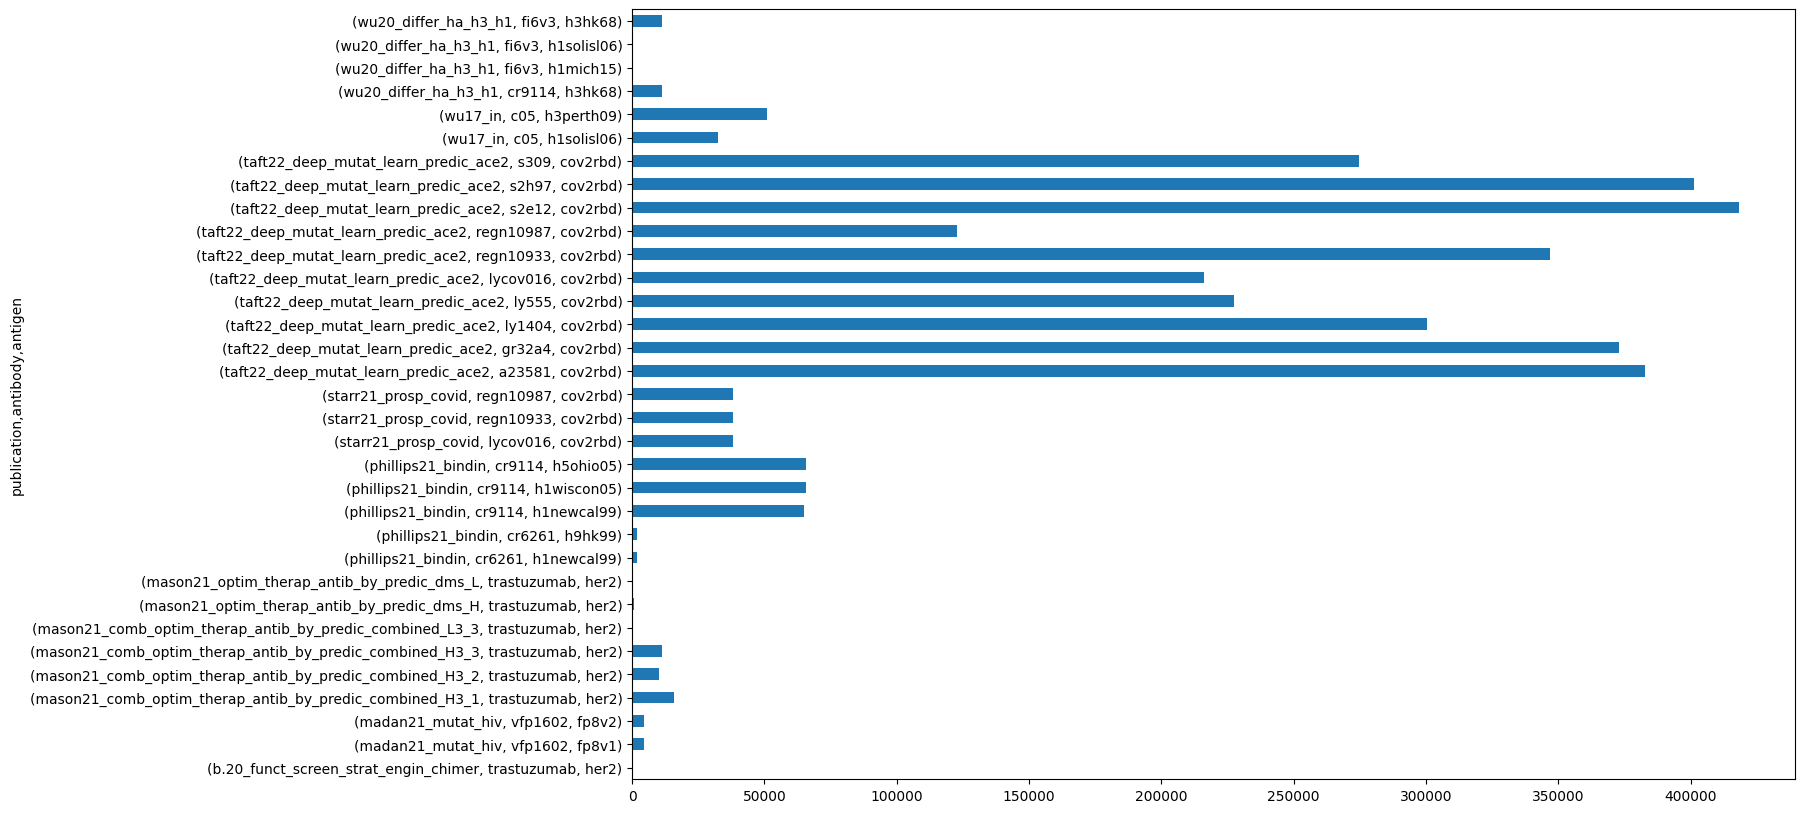

In [27]:
complexes["mutation_code"].count().plot(kind="barh", figsize=(15, 10))

## Distribution of affinity values

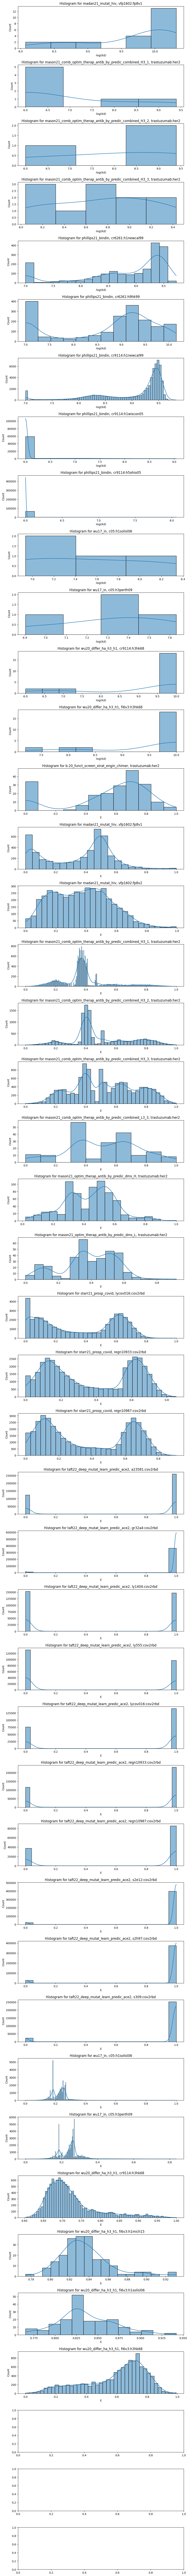

In [28]:
fig, axs = plt.subplots(figsize=(10,44 * 3), nrows=44)
fig.tight_layout(pad=4.0)

i = 0

for col in ["-log(Kd)","E"]:

    for group, idx in complexes.groups.items():
        group_df = dms_df.iloc[idx]

        if any(group_df[col].notnull()):

            sns.histplot(group_df, x=col, kde=True, ax=axs[i]).set_title(f"Histogram for {group[0]}, {group[1]}:{group[2]}")
            
            wt_values = group_df.loc[group_df["mutation_code"].isna(), col].values
            if len(wt_values) > 0:
                for wt_value in wt_values:
                    if not np.isnan(wt_value):
                        axs[i].axvline(wt_value, color="red")
            i += 1


## Error analysis of generation process

In [44]:
generation_log_path = os.path.join(config["DATASETS"]["path"], 
                                   config["DATASETS"]["DMS"]["folder_path"], 
                                   config["DATASETS"]["DMS"]["mutated_pdb_path"],
                                  "{}/{}_{}.logs")


In [45]:
all_logs = []
nologs = []

for group, idx in complexes.groups.items():
    publication, antibody, antigen = group
    group_log_path = generation_log_path.format(publication, antibody, antigen)
    if os.path.exists(group_log_path):
        group_logs = pd.read_csv(group_log_path)
        group_logs["publication"] = publication
        group_logs["antibody"] = antibody
        group_logs["antigen"] = antigen
        all_logs.append(group_logs)
    else:
        print(f"No logs available for {publication}:{antibody}:{antigen}")
        nologs.append(f"{publication}:{antibody}:{antigen}")
        
all_logs = pd.concat(all_logs)
all_logs.reset_index(inplace=True, drop=True)


No logs available for taft22_deep_mutat_learn_predic_ace2:ly1404:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:ly555:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:lycov016:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:regn10933:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:regn10987:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:s2e12:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:s2h97:cov2rbd
No logs available for taft22_deep_mutat_learn_predic_ace2:s309:cov2rbd


In [46]:
publications = dms_df.groupby("publication")
for publication, idx in publications.groups.items():
    print(len(dms_df.iloc[idx]["mutation_code"].unique()), ":", publication)
    print()

191 : b.20_funct_screen_strat_engin_chimer

527 : madan21_mutat_hiv

15834 : mason21_comb_optim_therap_antib_by_predic_combined_H3_1

10149 : mason21_comb_optim_therap_antib_by_predic_combined_H3_2

11306 : mason21_comb_optim_therap_antib_by_predic_combined_H3_3

186 : mason21_comb_optim_therap_antib_by_predic_combined_L3_3

695 : mason21_optim_therap_antib_by_predic_dms_H

341 : mason21_optim_therap_antib_by_predic_dms_L

9181 : phillips21_bindin

2 : starr21_prosp_covid

1594539 : taft22_deep_mutat_learn_predic_ace2

1 : wu17_in

5677 : wu20_differ_ha_h3_h1



In [47]:
all_mut = (dms_df["mutation_code"] == dms_df["original_mutation"]).sum()
print(f"In total {all_mut:,} of {len(dms_df):,} jobs have complete mutations ")


different_mut = ((dms_df["mutation_code"] != dms_df["original_mutation"]) & ~dms_df["mutation_code"].isna() & (dms_df["mutation_code"] != "original")).sum()
print(f"In total {different_mut:,} of {len(dms_df):,} jobs have different mutations ")


original = ((dms_df["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(dms_df):,} jobs are original pdb (no mutation)")


no_mut = (dms_df["mutation_code"].isna() | (dms_df["mutation_code"] == "original")).sum()
print(f"In total {no_mut:,} of {len(dms_df):,} jobs have no mutations ")


unique_data_points = len(dms_df.groupby("Unnamed: 0").groups.keys())
print(f"In total {unique_data_points:,} of {len(dms_df):,} are unique pdbs ")


print()

some_mut = ((dms_df["mutation_code"] != "original") &  (~dms_df["mutation_code"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(dms_df):,} jobs have some mutations (all or only a part)")

In total 488,341 of 3,530,892 jobs have complete mutations 
In total 2,472,694 of 3,530,892 jobs have different mutations 
In total 569,857 of 3,530,892 jobs are original pdb (no mutation)
In total 569,857 of 3,530,892 jobs have no mutations 
In total 1,690,708 of 3,530,892 are unique pdbs 

In total 2,961,035 of 3,530,892 jobs have some mutations (all or only a part)


In [48]:
dms_df["code"] = dms_df.apply(lambda row: ":".join([row["publication"], row["antibody"], row["antigen"] ]), axis=1)

In [49]:
print("Info for all logs available:", len(dms_df[~dms_df["code"].isin(nologs)]) == len(all_logs))

all_mut = (all_logs["mutation_code"] == all_logs["performed_mutations"]).sum()
print(f"In total {all_mut:,} of {len(all_logs):,} jobs have complete mutations ")


different_mut = ((all_logs["mutation_code"] != all_logs["performed_mutations"]) & ~all_logs["performed_mutations"].isna() & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed")) & (all_logs["performed_mutations"] != "[]")).sum()
print(f"In total {different_mut:,} of {len(all_logs):,} jobs have different mutations ")


original = ((all_logs["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(all_logs):,} jobs are original pdb (no mutation)")


no_mut = ((all_logs["performed_mutations"].isna()) & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed"))).sum()
print(f"In total {no_mut:,} of {len(all_logs):,} jobs have no mutations ")


failed_jobs = ((all_logs["status"] != "processed") & (all_logs["status"] != "already_processed")).sum()
print(f"In total {failed_jobs:,} of {len(all_logs):,} jobs failed")

print()

some_mut = ((all_logs["performed_mutations"] != "[]") &  (~all_logs["performed_mutations"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(all_logs):,} jobs have some mutations (all or only a part)")

Info for all logs available: False
In total 81,746 of 569,929 jobs have complete mutations 
In total 282,626 of 569,929 jobs have different mutations 
In total 20 of 569,929 jobs are original pdb (no mutation)
In total 202,427 of 569,929 jobs have no mutations 
In total 3,110 of 569,929 jobs failed

In total 364,372 of 569,929 jobs have some mutations (all or only a part)


In [50]:
#tests
assert some_mut == different_mut + all_mut

assert len(all_logs) == failed_jobs + original + no_mut + different_mut + all_mut

#### Get stats about performed mutations

In [52]:
all_logs["mutation_code"] = all_logs["mutation_code"].fillna("")
all_logs["num_mutations"] = all_logs["mutation_code"].apply(lambda x: len(x.split(";")) if x != "original" else 0 )
all_logs["num_performed_mutations"] = all_logs["performed_mutations"].apply(lambda x: len(x.split(";")) if isinstance(x, str) and x != "[]" else 0)

all_logs["num_not_performed_mutations"] = all_logs["num_mutations"] - all_logs["num_performed_mutations"]

In [53]:
all_logs.describe().loc[['mean','std', 'min', 'max']]

,num_mutations,num_performed_mutations,num_not_performed_mutations
mean,6.470164,4.281721,2.188443
std,3.200157,3.633513,1.600272
min,0.000000,0.000000,0.000000
max,16.000000,13.000000,9.000000


In [54]:
all_logs[all_logs["num_not_performed_mutations"] != 0].describe().loc[['mean','std', 'min', 'max']]

,num_mutations,num_performed_mutations,num_not_performed_mutations
mean,6.494007,3.939006,2.555001
std,3.320865,3.697413,1.432918
min,1.000000,0.000000,1.000000
max,16.000000,13.000000,9.000000


In [55]:
all_logs[all_logs["status"] != "processed"]

,mutation_code,performed_mutations,status,error_msg,publication,antibody,antigen,num_mutations,num_performed_mutations,num_not_performed_mutations
10,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
11,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
12,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
13,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
14,FE104E,FE104E,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
569924,IF48V;NF49W,IF48V;NF49W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
569925,NF49Y,NF49Y,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,1,1,0
569926,IF45R;QF47I,IF45R;QF47I,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
569927,DF46W;QF47W,DF46W;QF47W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0


In [56]:
all_logs[(~all_logs["performed_mutations"].isna()) & (all_logs["performed_mutations"] != "[]")]

,mutation_code,performed_mutations,status,error_msg,publication,antibody,antigen,num_mutations,num_performed_mutations,num_not_performed_mutations
14,FE104E,FE104E,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
18,GE100M,GE100M,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
20,DE108M,DE108M,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
21,DE108H,DE108H,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
22,AE106G,AE106G,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
569924,IF48V;NF49W,IF48V;NF49W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
569925,NF49Y,NF49Y,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,1,1,0
569926,IF45R;QF47I,IF45R;QF47I,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
569927,DF46W;QF47W,DF46W;QF47W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0


#### Check if all files exist

In [ ]:
generation_files_path = os.path.join(config["DATA"]["path"], 
                                   config["DATA"]["DMS"]["folder_path"], 
                                   config["DATA"]["DMS"]["mutated_pdb_path"],
                                  "all_generated_files.txt")

with open(generation_files_path) as f:
    lines = f.readlines()

lines = [ line.strip().split("/") for line in lines if line.strip()[-4:] == ".pdb"]
lines = [ {"publication": line[1], 
           "antibody": line[2].split("_")[0], 
           "antigen": line[2].split("_")[1],
           "mutation_code": line[3].split(".")[0]
          } for line in lines]

generated_files = pd.DataFrame(lines)

In [ ]:
all_files = all_logs.merge(generated_files, how='left', indicator=True, on=["publication", "antibody", "antigen", "mutation_code"])
all_files[all_files["_merge"] != "both"]

### Check for which files the performed mutation != mutation code

In [ ]:
mutation_not_in_interface = len(all_logs[all_logs["mutation_code"] != all_logs["performed_mutations"]])
print(f"For {mutation_not_in_interface} of {len(all_logs)} ({round(mutation_not_in_interface/len(all_logs)*100, 2)}%) files not all mutations have been in the inferface_hull")

In [ ]:
num_all_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "mutation_code"]))
unique_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "performed_mutations"]))
print(f"{unique_complexes} of {num_all_complexes} ({round(unique_complexes/num_all_complexes*100, 2)}%) are unique mutations")

### Get redudancy with AbAg Dataset

In [ ]:
all_logs[all_logs["performed_mutations"] == "SD167R;KD211D;AD216V"]